In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv("~/Downloads/sort.csv")
df.rnd = df.apply(axis=1, func = lambda x: x.n / 2)
df.shape

(8950, 11)

In [3]:
df.head(10)

,n,subtree_cnt,depth,avg_depth,max_depth,height,avg_height,max_height,loexpect,hiexpect,rnd
0,10,1,1,1.3,2,0,0.5,2,5.989362,4.010638,5.0
1,10,1,1,1.4,2,0,0.5,2,5.847222,4.152778,5.0
2,10,1,1,1.4,2,0,0.5,2,5.960000,4.040000,5.0
3,10,1,1,1.4,3,0,0.7,3,5.982323,4.017677,5.0
4,10,1,1,1.4,3,0,0.8,3,5.857843,4.142157,5.0
5,10,1,1,1.5,3,0,0.7,3,5.939394,4.060606,5.0
6,10,1,1,1.5,3,0,0.7,3,6.015152,3.984848,5.0
7,10,1,1,1.5,3,0,0.7,3,6.182390,3.817610,5.0
8,10,1,1,1.5,3,0,0.7,3,6.555556,3.444444,5.0
9,10,1,1,1.5,3,0,0.8,3,5.938596,4.061404,5.0


In [4]:
scaleSubtree = df.apply(axis=1, func = lambda x: x.subtree_cnt / x.n).rename("ssubtree")
scaleDepth = df.apply(axis=1, func = lambda x: x.depth / x.avg_depth).rename("sdepth")
scaleHeight = df.apply(axis=1, func = lambda x: x.height / x.avg_height).rename("sheight");

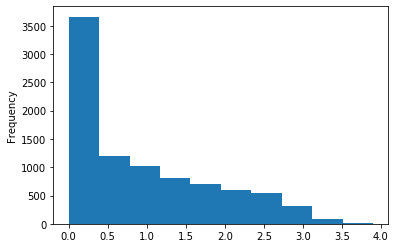

In [5]:
scaleHeight.plot(kind="hist");

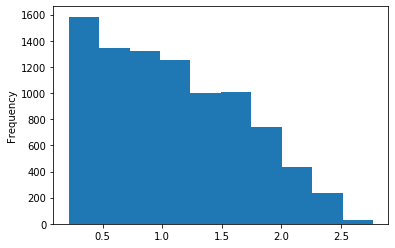

In [6]:
scaleDepth.plot(kind="hist");

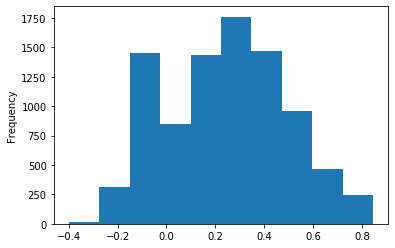

In [7]:
df['alt'] = df.apply(axis=1, func = lambda x: x.hiexpect if x.depth % 2 else x.loexpect)
importance = df.apply(axis=1, func = lambda x: (x.rnd-x.alt)/x.rnd)
#df['importance'] = np.power(relerr, 0.5); # TODO
importance.plot(kind="hist");

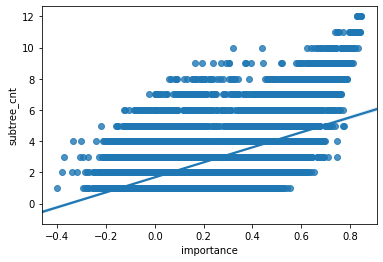

In [8]:
df['importance'] = importance
sns.regplot(x="importance", y="subtree_cnt", data=df);

In [9]:
df['isleaf'] = df.apply(axis=1, func = lambda x: x.height == 0)
df.head(5)

,n,subtree_cnt,depth,avg_depth,max_depth,height,avg_height,max_height,loexpect,hiexpect,rnd,alt,importance,isleaf
0,10,1,1,1.3,2,0,0.5,2,5.989362,4.010638,5.0,4.010638,0.197872,True
1,10,1,1,1.4,2,0,0.5,2,5.847222,4.152778,5.0,4.152778,0.169444,True
2,10,1,1,1.4,2,0,0.5,2,5.960000,4.040000,5.0,4.040000,0.192000,True
3,10,1,1,1.4,3,0,0.7,3,5.982323,4.017677,5.0,4.017677,0.196465,True
4,10,1,1,1.4,3,0,0.8,3,5.857843,4.142157,5.0,4.142157,0.171569,True


In [10]:
posBins = 8;
base = 1.2;
ranges=[]

denom = (np.power(base, posBins) - 1) / (base - 1);
for i in range(0, posBins):
    ranges.insert(0, np.power(base, i)/denom)
for i in range(1, posBins):
    ranges[i] += ranges[i-1]
ranges[-1] = 1.0

print(ranges)

def findBin(x):
    if (x < 0):
        return -1
    for i in range(0, posBins):
        if x < ranges[i]:
            return i
    return np.nan

y = df.importance.apply(findBin)
print("total NA:", y.isna().sum())
print("max importance:", df.importance.max())

[0.21717451867390852, 0.39815328423549895, 0.548968922203491, 0.6746486205101511, 0.7793817024323677, 0.8666592707008817, 0.93939057759131, 1.0]
total NA: 0
max importance: 0.8462581333333333


[0.21717451867390852, 0.39815328423549895, 0.548968922203491, 0.6746486205101511, 0.7793817024323677, 0.8666592707008817]


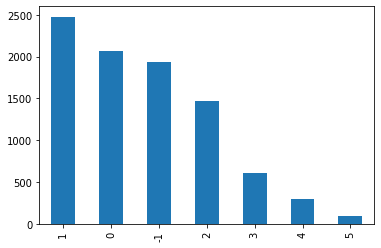

In [11]:
maxBinIdx = y.value_counts().index.max()
posBins = maxBinIdx + 1
ranges = ranges[0:posBins]

print(ranges)

y = df.importance.apply(findBin)
y.value_counts().plot(kind="bar");

In [12]:
X = pd.DataFrame([scaleSubtree, scaleDepth, scaleHeight, df.isleaf, df.max_depth, df.max_height]).transpose()
X.head(5)

,ssubtree,sdepth,sheight,isleaf,max_depth,max_height
0,0.1,0.769231,0.0,1.0,2.0,2.0
1,0.1,0.714286,0.0,1.0,2.0,2.0
2,0.1,0.714286,0.0,1.0,2.0,2.0
3,0.1,0.714286,0.0,1.0,3.0,3.0
4,0.1,0.714286,0.0,1.0,3.0,3.0


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=83)
model = RandomForestClassifier(max_depth=8, n_estimators=200, random_state=82).fit(X_train, y_train)

print("train score:", model.score(X_train, y_train))
print("test score:", model.score(X_test, y_test))

train score: 0.816746126340882
test score: 0.7837354781054513


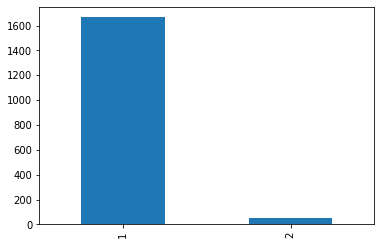

In [14]:
wrongBins = np.abs(model.predict(X)-y)
wrongBins[wrongBins != 0].value_counts().plot(kind="bar");

In [15]:
X_anal = pd.DataFrame([model.predict(X), y]).transpose()
X_anal = X_anal.rename(columns={0: 'predict', 1: 'expected'})
X_anal = pd.concat([df, X_anal], axis=1)

X_anal[y == 4].head(10)

,n,subtree_cnt,depth,avg_depth,max_depth,height,avg_height,max_height,loexpect,hiexpect,rnd,alt,importance,isleaf,predict,expected
538,10,5,2,2.1,5,3,1.5,5,1.620690,8.379310,5.0,1.620690,0.675862,False,2,4
575,10,6,2,2.4,5,3,1.6,5,1.307692,8.692308,5.0,1.307692,0.738462,False,4,4
576,10,6,2,2.5,5,3,1.5,5,1.350000,8.650000,5.0,1.350000,0.730000,False,4,4
577,10,6,2,2.6,5,3,1.5,5,1.600000,8.400000,5.0,1.600000,0.680000,False,4,4
578,10,6,2,2.6,6,4,2.1,6,1.408163,8.591837,5.0,1.408163,0.718367,False,4,4
579,10,6,2,2.7,6,4,2.1,6,1.451613,8.548387,5.0,1.451613,0.709677,False,4,4
580,10,6,2,2.8,6,4,2.1,6,1.422222,8.577778,5.0,1.422222,0.715556,False,4,4
581,10,6,2,2.9,6,4,2.1,6,1.380952,8.619048,5.0,1.380952,0.723810,False,4,4
585,10,7,1,2.0,4,3,1.1,4,8.420290,1.579710,5.0,1.579710,0.684058,False,4,4
586,10,7,1,2.1,4,3,1.1,4,8.488889,1.511111,5.0,1.511111,0.697778,False,4,4


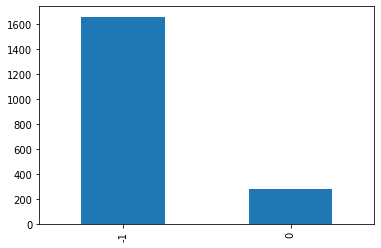

In [16]:
X_anal[X_anal.expected == -1].predict.value_counts().plot(kind="bar");

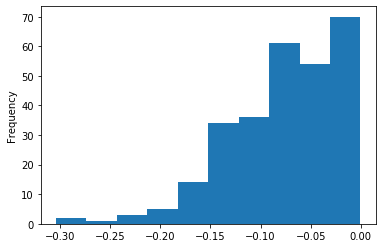

In [17]:
X_anal[(X_anal.expected == -1) & (X_anal.predict != -1)].importance.plot(kind="hist");

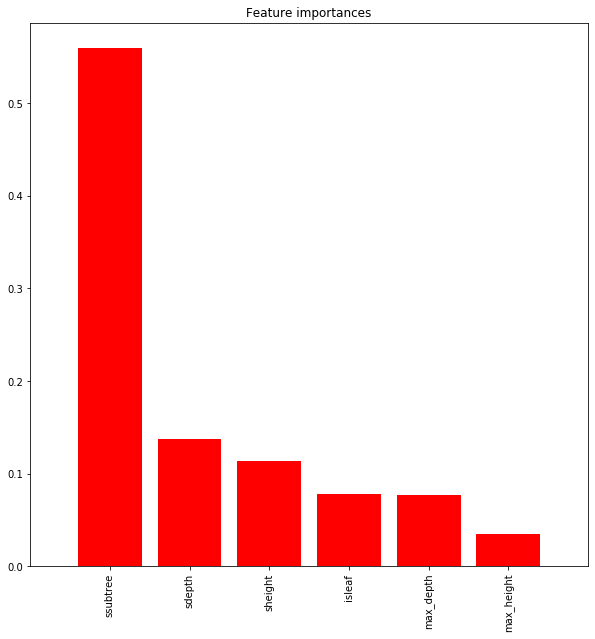

In [18]:
def random_forest_features(model, X, top=-1):
    importances = model.feature_importances_
    std = np.std([model.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1][:top]
    
    plt.figure(figsize=(10, 10))
    plt.title("Feature importances")
    plt.bar(range(indices.size), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(indices.size), X.columns, rotation='vertical')
    plt.xlim([-1, indices.size])
    plt.show()

random_forest_features(model, X, top=20)

In [19]:
#fig = plt.figure(figsize=(5, 15))
#ax1 = fig.add_subplot (6, 1, 1)
#ax2 = fig.add_subplot (6, 1, 2)
#ax3 = fig.add_subplot (6, 1, 3)
#ax4 = fig.add_subplot (6, 1, 4)
#ax5 = fig.add_subplot (6, 1, 5)
#ax6 = fig.add_subplot (6, 1, 6)

#pd.Series(model.predict_proba(X)[:,0])[y==-1].plot(ax=ax1, kind="hist");
#pd.Series(model.predict_proba(X)[:,1])[y==0].plot(ax=ax2, kind="hist");
#pd.Series(model.predict_proba(X)[:,2])[y==1].plot(ax=ax3, kind="hist");
#pd.Series(model.predict_proba(X)[:,3])[y==2].plot(ax=ax4, kind="hist");
#pd.Series(model.predict_proba(X)[:,4])[y==3].plot(ax=ax5, kind="hist");
#pd.Series(model.predict_proba(X)[:,5])[y==4].plot(ax=ax6, kind="hist");

In [20]:
mids = [df.importance[df.importance < 0].mean()]
mids.append(ranges[0] / 2)
for i in range(0, len(ranges)-1):
    mids.append(ranges[i]*0.5 + ranges[i+1]*0.5)
print(mids)

[-0.10043076827441082, 0.10858725933695426, 0.30766390145470374, 0.47356110321949496, 0.611808771356821, 0.7270151614712594, 0.8230204865666246]


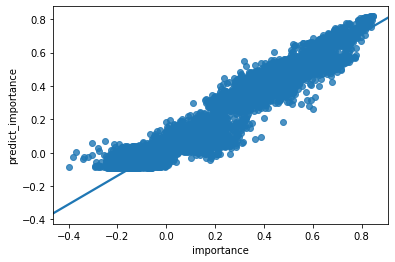

In [21]:
predictImportance = pd.Series(model.predict_proba(X).dot(mids)).rename("predict_importance")
sns.regplot(x=df.importance, y=predictImportance);

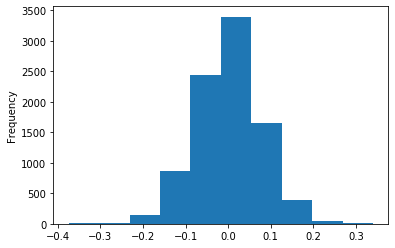

In [22]:
(df.importance-predictImportance).plot(kind="hist");

In [23]:
pd.DataFrame([df.importance, predictImportance]).transpose().head(15)

,importance,predict_importance
0,0.197872,0.124902
1,0.169444,0.124331
2,0.192000,0.124331
3,0.196465,0.214706
4,0.171569,0.214706
5,0.187879,0.221702
6,0.203030,0.221702
7,0.236478,0.221702
8,0.311111,0.221702
9,0.187719,0.221702


In [24]:
from sklearn.externals import joblib

joblib.dump(model, 'predict.model');